End-to-end overview of wrfhydropy
==============================

The goal of this example is to show both the model API and the ability of `wrfhydropy` to interact with model inputs and outputs. 

## Description of this example
A a high level this example does the following: 

1. Establishes configuration and where the experiments will be run on file
1. Downloads the croton_NY domain
1. Instantiates a Domain object
1. Instantiates a Model object and compiles it
1. Instantiates a Job object
1. Instantiates, builds, composes, and runs a Simulation object
1. Visualizes the simulation run
1. Edits a routelink file
1. Instantiates, edits, composes, and runs an Ensemble object
1. Visualizes the ensemble run
1. Instantiates, edits, composes, and runs an EnsembleCycle object
1. Visualizes the ensemble forecast
1. Evaluates the ensemble forecast

## Preliminaries
Steps to gather the required inputs and setup where the example will be run.

First define the python libraries we will use. The `wrfhydropy` library should have previously been installed. See installing

In [1]:
import os
import pathlib
import shlex
import subprocess
import sys
import wrfhydropy
user = 'jamesmcc'

A clone of the `wrf_hydro_nwm_public` needs to be available locally.

In [2]:
model_repo = pathlib.Path(
    '/glade/u/home/' + user + '/WRF_Hydro/wrf_hydro_nwm_public')

Define where the example/experiment will be located on the file system.

In [3]:
experiment_dir = pathlib.Path(
    '/glade/scratch/' + user + '/wrfhydropy_end-to-end_example')

In [4]:
if not experiment_dir.exists():
    os.mkdir(str(experiment_dir))
os.chdir(str(experiment_dir))

When it does not previously exist, we will download the croton_NY domain in to a subdirectory of the experiment directory, the `domain_dir`.

In [5]:
domain_dir = experiment_dir / 'domain'
if not domain_dir.exists(): 
    sys.path.append(str(model_repo / 'tests/local/utils'))
    from gdrive_download import download_file_from_google_drive
    file_id = '1xFYB--zm9f8bFHESzgP5X5i7sZryQzJe'
    file_target = 'gdrive_testcase.tar.gz'
    download_file_from_google_drive(
        file_id, 
        str(experiment_dir.joinpath(file_target)))
    untar_cmd = 'tar -xf ' + file_target + '; mv example_case domain'
    subprocess.run(
        untar_cmd, 
        shell=True,
        cwd=str(experiment_dir))

## Namelists and configurations in wrfhydropy

The wrfhydropy package introduces some complexity to the standard concept of the model namelists. This is done for the purposes of being able to easily swap domains while maintaining a certain "configuration". 

For example, there is a configuration which is the "Analysis and Assimilation" configuration of the NWM. For the purposes of the WRF-Hydro model itself, this simply means some specific namelists ([for example, v2.0](https://github.com/NCAR/wrf_hydro_nwm_public/tree/master/trunk/NDHMS/template/WCOSS/namelists/v2.0/analysis_assim)). (In terms of operational execution, i.e. cycling and file inputs, the true configuration or output of the model is actually defined by some larger set or scripts run in operations. This is something that wrfhydropy could more fully mimic, but this is not what we are talking about here.) The namelists here reference a specific domain or set of domain files, which is the CONUS domain of the NWM. It is concievable that we would want to run this "configuraton" on a different domain while keeping as much as possible identical. 

For this reason, we separate the standard WRF-Hydro namelists in to two parts: domain-side and model-side namelists. Because WRF-Hydro begins with 2 namelist files, the result is 4 namelist files. 


| WRF-Hydro namelist file |->| wrfhydropy model-side *example* file | wrfhydropy domain-side *example* file |
|-------------------------|--|--------------------------------------|---------------------------------------|
| namelist.hrldas         |->| hrldas_namelists.json                | hrldas_namelist_patches.json          |
| hydro.namelist          |->| hrldas_namelists.json                | hydro_namelist_patches.json           |

The user presents `wrfhydropy` with the files in two right-hand columns and it creates the files in the left-hand columns. The files in the left-hand column have specific names, which must be hard-wired into the WRF-Hydro code. The files supplied to `wrfhydropy` do not need specific names, the names here are the conventions we have used in `wrf_hydro_nwm_public` (model-side) and in the `croton_NY` domain (domain-side) which has been downloaded. The configurations defined in these files are used for the purposes of model testing (they are not operational configurations _per se_). 

### Model-side namelists
As mentioned, for testing purposes we have created model-side namelists in `wrf_hydro_nwm_public`. We can examine those in our clone of the repository. 

In [6]:
hrldas_model_side = model_repo / 'trunk/NDHMS/hrldas_namelists.json'
with open(hrldas_model_side, 'r') as file:
    print(file.read())

{
    "base": {
        "noahlsm_offline": {
            "btr_option": 1,
            "canopy_stomatal_resistance_option": 1,
            "dynamic_veg_option": 4,
            "forcing_timestep": "NULL_specified_in_domain.json",
            "frozen_soil_option": 1,
            "glacier_option": 2,
            "hrldas_setup_file": "NULL_specified_in_domain.json",
            "indir": "NULL_specified_in_domain.json",
            "khour": 144,
            "noah_timestep": 3600,
            "nsoil": 4,
            "outdir": "./",
            "output_timestep": 3600,
            "pcp_partition_option": 1,
            "radiative_transfer_option": 3,
            "restart_filename_requested": "NULL_specified_in_domain.json",
            "restart_frequency_hours": 24,
            "rst_bi_in": 0,
            "rst_bi_out": 0,
            "runoff_option": 3,
            "snow_albedo_option": 1,
            "soil_thick_input": [0.1, 0.3, 0.6, 1.0],
            "spatial_filename": "NULL_specified_in_

This file is a JSON file with hierarchical data structures. At the top you'll noe the `base` configuration. This one sets the basis for the other named configuratons which follow, which only specify differences from this base. You can see that the `base` config is identical to both the `nwm_ana` and `nwm_long_range` configurations (among others) and that differences from `base` are succinctly summarized in the other named configurations. 

The next thing to notice is are lines like: `"forcing_timestep": "NULL_specified_in_domain.json"`. This value of the field indicates that it is considered a domain-side option and its value is to come from the domain-side file (and the specified configuration for that file).

In [7]:
hydro_model_side = model_repo / 'trunk/NDHMS/hydro_namelists.json'
with open(hydro_model_side, 'r') as file:
    print(file.read())

{
    "base": {
        "hydro_nlist": {
            "aggfactrt": 4,
            "channel_option": 2,
            "chanobs_domain": 1,
            "chanrtswcrt": 1,
            "chrtout_domain": 1,
            "chrtout_grid": 1,
            "compound_channel": true,
            "dtrt_ch": 300,
            "dtrt_ter": 10,
            "dxrt": 250,
            "frxst_pts_out": 0,
            "geo_finegrid_flnm": "NULL_specified_in_domain.json",
            "geo_static_flnm": "NULL_specified_in_domain.json",
            "gw_restart": 1,
            "gwbaseswcrt": 4,
            "gwbuckparm_file": "NULL_specified_in_domain.json",
            "hydrotbl_f": "NULL_specified_in_domain.json",
            "igrid": 1,
            "io_config_outputs": 0,
            "io_form_outputs": 4,
            "land_spatial_meta_flnm": "NULL_specified_in_domain.json",
            "lsmout_domain": 1,
            "nsoil": 4,
            "order_to_write": 1,
            "out_dt": 60,
            "outlake": 1,
  

The model-side hydro namelist file is exactly as the model-side hrldas namelist file. It's just a different set of options. 

### Domain-side namelists

As for model-side namelists, a `base` namelist is used. And, as foreshadowed, only the domain-side options appear in this file. 

In [8]:
hrldas_domain_side = domain_dir / 'hrldas_namelist_patches.json'
with open(hrldas_domain_side, 'r') as file:
    print(file.read())

{
    "base": {            
        "noahlsm_offline": {
            "hrldas_setup_file": "./NWM/DOMAIN/wrfinput_d01.nc",
            "khour": 144,
            "indir": "./FORCING",
            "forcing_timestep": 3600,
            "spatial_filename": "./NWM/DOMAIN/soil_properties.nc",
            "restart_filename_requested": "./NWM/RESTART/RESTART.2011082600_DOMAIN1",
            "start_year": 2011,
            "start_month": 8,
            "start_day": 26,
            "start_hour": 0,
            "start_min": 0
        },
        "wrf_hydro_offline": {
            "forc_typ": 1
        }
    },
    "nwm_ana": {
        "noahlsm_offline": {},
        "wrf_hydro_offline": {}
    },

    "nwm_short_range" : {
        "noahlsm_offline": {},
        "wrf_hydro_offline": {}
    },

    "nwm_medium_range" : {
        "noahlsm_offline": {},
        "wrf_hydro_offline": {}
    },

    "nwm_long_range" : {
        "noahlsm_offline": {
            "hrldas_setup_file": "./NWM/DOMAIN_LR/wrfinput

We do not show the hydro_namelist_patches.json, it is very similar and can be examined by the user. 

To summarize the namelist handling of `wrfhydropy`: while `wrfhydropy` breaks the native WRF-Hydro namelists into parts, the files we use to build the native namelists may contain many named configurations which can be specified as deviations from a `base` config in that file. The model-side namelists contain the full set of WRF-Hydro options and where an option is considered domain-side that option's value is set to `NULL_specified_in_domain.json`. The domain-side namelist contains only the options relevant to the domain, for the base and each named configuration.

## Configuration

We will use the named configuration `nwm_ana` which was seen in the above namelists. 

In [9]:
config = 'nwm_ana'

## Domain object

In [10]:
domain = wrfhydropy.Domain(
    domain_top_dir=domain_dir,
    domain_config=config)
domain

## Model object

In [11]:
subprocess.run('module list', shell=True, stderr=subprocess.PIPE)

CompletedProcess(args='module list', returncode=0, stderr=b'\nCurrently Loaded Modules:\n  1) intel/18.0.5   3) ncarenv/1.3           5) openmpi/3.1.4\n  2) netcdf/4.7.3   4) ncarcompilers/0.5.0   6) nccmp/1.8.2.1\n\n \n\n')

The above shows that we are using the intel compiler for this example. You may need to change this to your machine.

In [12]:
model = wrfhydropy.Model(
    model_repo / 'trunk/NDHMS',
    compiler='ifort',
    model_config=config)
model

In [14]:
compile_dir = experiment_dir / 'compile'
if not compile_dir.exists():
    model.compile(compile_dir)

/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_py/wrfhydropy/core/model.py:193: UserWarning: /glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile directory does not exist, creating
  warnings.warn(str(self.compile_dir.absolute()) + ' directory does not exist, creating')


Model successfully compiled into /glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile


## Job object

The concept of a job is formalized in `wrfhydropy` and can have surprising consequences to the uninitiated. 

In [15]:
exe_cmd = 'mpirun -np 1 ./wrf_hydro.exe'

job_24hr = wrfhydropy.Job(
    job_id='24hr',
    exe_cmd = exe_cmd,
    model_start_time = '2011-08-26',
    model_end_time='2011-08-27',
    restart_freq_hr=24,
    output_freq_hr=1)

job_145hr = wrfhydropy.Job(
    job_id='145hr',
    exe_cmd = exe_cmd,
    model_start_time = '2011-08-27',
    model_end_time='2011-09-02',
    restart_freq_hr=24,
    output_freq_hr=1,
    restart_dir='.')

## Scheduler object
We do not use a scheduler object in this example, but we provide an instance of one and describe how it is used and how it affects the running the model.

#Use a scheduler for the ensemble or the or the ens forecast? or use teams

In [ ]:
sched = wrfhydro.PBSCheyenne()

## Simulation object: interactive

In [22]:
simulation = wrfhydropy.Simulation()
simulation.add(model)
simulation.add(domain)
simulation.add(job_24hr)
simulation.add(job_145hr)

In [23]:
sim_dir = experiment_dir / 'simulation'
os.mkdir(sim_dir)
os.chdir(sim_dir)
simulation.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation'
Getting domain files...
Making job directories...
Validating job input files
24hr
145hr
Model already compiled, copying files...
Simulation successfully composed


In [24]:
simulation.run()


Running job 24hr: 
    Wall start time: 2020-01-17 13:35:13
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-27 00:00

Running job 145hr: 
    Wall start time: 2020-01-17 13:35:22
    Model start time: 2011-08-27 00:00
    Model end time: 2011-09-02 00:00


0

In [25]:
simulation.collect()

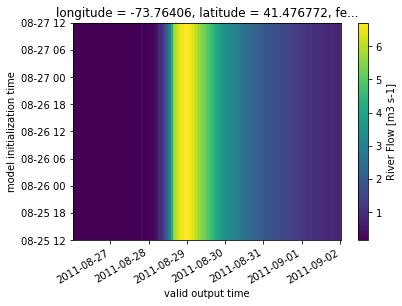

In [31]:
from matplotlib import pyplot as plt
simulation.output.channel_rt.open(forecast=False).sel(feature_id=6226932).streamflow.plot()